In [1]:
#import required libs
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
%matplotlib inline

### Image Pre-processing

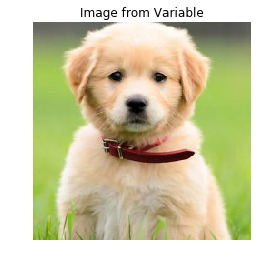

In [177]:
# Loads image from filename, 
# Resizes it to indicated size 
# Normalizes the image as vgg19 was trained on normalized images
# Converts it into a Variable whose gradient can be taken
# Also adds a fake batch dimension to image, making it ready to be inputted into vgg19
def load_image(filename, size):
    image = Image.open(filename)
    loader = transforms.Compose([
        transforms.Resize((240,240)),  
        transforms.ToTensor()
    ])
    
    image_tensor = loader(image).unsqueeze(0)
    mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406])).view(-1, 1, 1)
    std = torch.tensor(torch.tensor([0.229, 0.224, 0.225])).view(-1, 1, 1)
    image_tensor_normalized = (image_tensor - mean) / std
    
    image_variable = Variable(image_tensor_normalized, requires_grad=True)
    assert(image_variable.size() == torch.Size([1, 3, 240, 240]))
    
    return image_variable


# Grab image, need it to be 240x240
image_var = load_image("./dog.jpg", (240,240))


# Displays the image from its tensor (think modified image tensor, after adding epsilon noise)
def show_image(tensor, title=None):
    image = tensor.clone()        # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    
    mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406])).view(-1, 1, 1)
    std = torch.tensor(torch.tensor([0.229, 0.224, 0.225])).view(-1, 1, 1)
    image_tensor_unnormalized = (image * std) + mean
    
    unloader = transforms.ToPILImage()
    image_final = unloader(image_tensor_unnormalized)
    
    plt.figure()
    plt.axis('off')
    plt.imshow(image_final)
    
    if title is not None:
        plt.title(title)
        
    return


show_image(image_var.data, title='Image from Variable')

### Model: VGG19 (State-of-the-art, pre-trained)
Needs images resized to 240x240

In [3]:
cnn = models.vgg19(pretrained=True).eval()

### Classifying image and showing top 10 classes

In [4]:
# Let's try classifying the image
image_trial = load_image("./dog.jpg", (240,240))
output = cnn(image_trial)

# Prints the top k classes with the confidence levels from the out=model(image) variable
def top_k(out, k=10):
    # Get most probable class
    label_idx = torch.max(out.data, 1)[1][0]

    # Have an output tensor of classes and values per class
    # Need a mapping from class indices to class names
    with open('imagenet_class_index.json') as f: class_idx = json.load(f)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

    # Get top 10 labels
    labels = [idx2label[idx] for idx in out[0].sort()[1][-k:]]
    labels.reverse()

    # Also need to pass the tensor to softmax for probability dist on classes for confidence level
    confidences = F.softmax(out, dim=1)

    # Get top 10 confidences
    confidences = list(np.asarray(confidences.data.sort()[0][0]))
    confidences.reverse()

    for i in range(k):
        print(labels[i], confidences[i]*100, '%')
        
    return

top_k(output)

golden_retriever 96.53496146202087 %
Labrador_retriever 2.170245535671711 %
tennis_ball 0.3255081130191684 %
kuvasz 0.1784397754818201 %
soccer_ball 0.17493321793153882 %
Great_Pyrenees 0.11685092467814684 %
clumber 0.10115603217855096 %
Border_collie 0.06372759817168117 %
Sussex_spaniel 0.056562724057585 %
Brittany_spaniel 0.04760420706588775 %


### Add perturbations to get another class with 99% accuracy
We use FGSM, find perturbations which increase the loss for the true class subsequently leading to misclassification. Also, FGSM is a non-targeted method. We can easily convert it into targeted method by maximizing probability $P(Y_{target}|X)$ for some target class $Y_{target}$ and input image $X$. 

For a neural network with cross-entropy loss $J(X,Y)$, the formula will be:
$$X_{adversarial}=X_{input}− \epsilon \cdot \text{sign}(\nabla_X J(X, Y_{target})$$
 
Instead of adding perturbation to the original input, we need to remove it from the original input. 

We build this mechanism such that we can target any desired class. We need to iterate a number of times to max out the confidence level on the target class. 

In [174]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([9]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 0.05

# Max iterations
num_steps = 25

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./dog.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)
    
    # Zero out grads outside these row and column indices
    row_min = 10
    row_max = 120
    col_min = 30
    col_max = 150
    
    grad[:, :, :row_min, :] = 0
    grad[:, :, row_max:, :] = 0
    grad[:, :, :, :col_min] = 0
    grad[:, :, :, col_max:] = 0
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


golden_retriever 16.66223108768463 %
Tibetan_terrier 8.831573277711868 %
Norfolk_terrier 8.291947096586227 %
tennis_ball 5.6208062916994095 %
soccer_ball 3.4863952547311783 %
Dandie_Dinmont 3.0814945697784424 %
otterhound 2.6134267449378967 %
Lhasa 2.4480322375893593 %
Maltese_dog 2.319379895925522 %
clumber 1.8078263849020004 %


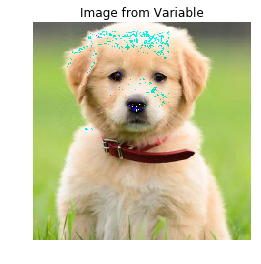

In [178]:
top_k(cnn(image_start))

show_image(image_start, title='Image from Variable')